## **Going Deeper 1. ResNet Ablation Study**

### Attachment.Resnet-50

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

In [3]:
def res_identity(x, filters): 
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer='he_normal', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer='he_normal', use_bias=False)(x)
  x = BatchNormalization()(x)
  # x = Activation(activations.relu)(x)

  # add the input 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [4]:
def res_conv(x, s, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_initializer='he_normal', use_bias=False)(x)
  # when s = 2 then it is like downsizing the feature map
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer='he_normal', use_bias=False)(x)
  x = BatchNormalization()(x)

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_initializer='he_normal', use_bias=False)(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [5]:
def resnet50(input_shape=(32,32,3), num_class=10):

  input_im = Input(shape=input_shape)
  x = ZeroPadding2D(padding=(3, 3))(input_im)

  # 1st stage
  # here we perform maxpooling, see the figure above

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage 
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))

  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))

  # 5th stage

  x = res_conv(x, s=2, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))

  # ends with average pooling and dense connection

  x = AveragePooling2D(padding='same')(x)
  x = Flatten()(x)
  x = Dense(512, activation='relu', name='fc1')(x)
  x = Dense(num_class, activation='softmax', kernel_initializer='he_normal')(x) #multi-class

  # define the model 

  model = Model(inputs=input_im, outputs=x, name='Resnet50')

  return model

In [6]:
resnet_50 = resnet50(input_shape=(224,224,3))
resnet_50.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
___________________________________________________________________________________________

In [8]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [9]:
import urllib3
urllib3.disable_warnings()

tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[20%:]', 'train[:20%]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True
)

In [10]:
# 각 채널별 최댓값인 255로 정규화(normalize)
# 이미지 크기가 제각각이므로 160,160으로 통일시킨다.

def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [11]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [12]:
BATCH_SIZE = 32
EPOCH = 15

In [13]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [14]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[20%:]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[:20%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 26/581 [>.............................] - ETA: 2:46 - loss: 2.6153 - accuracy: 0.4784

 38/581 [>.............................] - ETA: 2:42 - loss: 2.1648 - accuracy: 0.4786

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 71/581 [==>...........................] - ETA: 2:33 - loss: 1.7394 - accuracy: 0.4886

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


110/581 [====>.........................] - ETA: 2:22 - loss: 1.6017 - accuracy: 0.4920

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 2:19 - loss: 1.5510 - accuracy: 0.4927

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


242/581 [===========>..................] - ETA: 1:42 - loss: 1.2178 - accuracy: 0.4972

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


319/581 [===============>..............] - ETA: 1:18 - loss: 1.0972 - accuracy: 0.4983

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 1:15 - loss: 1.0830 - accuracy: 0.4987

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 1:11 - loss: 1.0707 - accuracy: 0.4995

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


369/581 [==================>...........] - ETA: 1:03 - loss: 1.0440 - accuracy: 0.4980

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 1:01 - loss: 1.0377 - accuracy: 0.4983

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 0.9207 - accuracy: 0.4970

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.9200 - accuracy: 0.4972

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


581/581 [==============================] - 241s 332ms/step - loss: 0.9200 - accuracy: 0.4972 - val_loss: 0.6969 - val_accuracy: 0.5071
Epoch 2/15
 27/581 [>.............................] - ETA: 2:44 - loss: 0.6996 - accuracy: 0.4803

 39/581 [=>............................] - ETA: 2:42 - loss: 0.6993 - accuracy: 0.4920

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 73/581 [==>...........................] - ETA: 2:31 - loss: 0.7013 - accuracy: 0.4936

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


109/581 [====>.........................] - ETA: 2:20 - loss: 0.7019 - accuracy: 0.4923

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


123/581 [=====>........................] - ETA: 2:16 - loss: 0.7017 - accuracy: 0.4929

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


241/581 [===========>..................] - ETA: 1:39 - loss: 0.6996 - accuracy: 0.4984

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 1:16 - loss: 0.6997 - accuracy: 0.4992

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 1:13 - loss: 0.6996 - accuracy: 0.4983

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 1:09 - loss: 0.6995 - accuracy: 0.4976

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


369/581 [==================>...........] - ETA: 1:02 - loss: 0.6985 - accuracy: 0.5023

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 1:01 - loss: 0.6990 - accuracy: 0.5018

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


578/581 [============================>.] - ETA: 0s - loss: 0.6990 - accuracy: 0.4988

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6990 - accuracy: 0.4987

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


581/581 [==============================] - 187s 323ms/step - loss: 0.6990 - accuracy: 0.4987 - val_loss: 0.6950 - val_accuracy: 0.5035
Epoch 3/15
 28/581 [>.............................] - ETA: 2:39 - loss: 0.6973 - accuracy: 0.4887

 40/581 [=>............................] - ETA: 2:36 - loss: 0.6970 - accuracy: 0.4953

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 74/581 [==>...........................] - ETA: 2:27 - loss: 0.6971 - accuracy: 0.5017

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


110/581 [====>.........................] - ETA: 2:17 - loss: 0.6966 - accuracy: 0.5057

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


123/581 [=====>........................] - ETA: 2:13 - loss: 0.6966 - accuracy: 0.5033

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


243/581 [===========>..................] - ETA: 1:38 - loss: 0.6976 - accuracy: 0.4996

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


319/581 [===============>..............] - ETA: 1:16 - loss: 0.6978 - accuracy: 0.5020

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 1:12 - loss: 0.6978 - accuracy: 0.5019

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 1:08 - loss: 0.6977 - accuracy: 0.5005

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 1:00 - loss: 0.6974 - accuracy: 0.5010

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 58s - loss: 0.6977 - accuracy: 0.5007

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6979 - accuracy: 0.5004

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


581/581 [==============================] - 187s 321ms/step - loss: 0.6979 - accuracy: 0.5004 - val_loss: 0.7037 - val_accuracy: 0.5002
Epoch 4/15


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 29/581 [>.............................] - ETA: 2:40 - loss: 0.6965 - accuracy: 0.5022

 41/581 [=>............................] - ETA: 2:36 - loss: 0.6969 - accuracy: 0.5000

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/581 [==>...........................] - ETA: 2:27 - loss: 0.6980 - accuracy: 0.4967

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


111/581 [====>.........................] - ETA: 2:17 - loss: 0.6987 - accuracy: 0.4966

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


124/581 [=====>........................] - ETA: 2:13 - loss: 0.6985 - accuracy: 0.4947

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


243/581 [===========>..................] - ETA: 1:38 - loss: 0.6982 - accuracy: 0.4973

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 1:15 - loss: 0.6980 - accuracy: 0.5031

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 1:11 - loss: 0.6979 - accuracy: 0.5035

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 1:07 - loss: 0.6978 - accuracy: 0.5039

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 1:00 - loss: 0.6978 - accuracy: 0.5034

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 58s - loss: 0.6979 - accuracy: 0.5035

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6971 - accuracy: 0.5064

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


581/581 [==============================] - 185s 319ms/step - loss: 0.6971 - accuracy: 0.5064 - val_loss: 0.6954 - val_accuracy: 0.5017
Epoch 5/15


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 30/581 [>.............................] - ETA: 2:40 - loss: 0.6998 - accuracy: 0.4854

 41/581 [=>............................] - ETA: 2:36 - loss: 0.6984 - accuracy: 0.4855

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 76/581 [==>...........................] - ETA: 2:27 - loss: 0.6968 - accuracy: 0.5021

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


112/581 [====>.........................] - ETA: 2:16 - loss: 0.6959 - accuracy: 0.5086

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


126/581 [=====>........................] - ETA: 2:12 - loss: 0.6964 - accuracy: 0.5094

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


244/581 [===========>..................] - ETA: 1:37 - loss: 0.6985 - accuracy: 0.4986

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 1:14 - loss: 0.6988 - accuracy: 0.4974

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 1:11 - loss: 0.6987 - accuracy: 0.4984

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 1:08 - loss: 0.6987 - accuracy: 0.4986

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 1:00 - loss: 0.6987 - accuracy: 0.4975

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 58s - loss: 0.6987 - accuracy: 0.4971

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6993 - accuracy: 0.4976

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


581/581 [==============================] - 186s 319ms/step - loss: 0.6993 - accuracy: 0.4976 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 6/15
  2/581 [..............................] - ETA: 2:55 - loss: 0.6957 - accuracy: 0.4219

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 32/581 [>.............................] - ETA: 2:43 - loss: 0.7094 - accuracy: 0.4854

 44/581 [=>............................] - ETA: 2:39 - loss: 0.7066 - accuracy: 0.4808

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 78/581 [===>..........................] - ETA: 2:28 - loss: 0.7020 - accuracy: 0.4896

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 2:16 - loss: 0.7012 - accuracy: 0.4893

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


125/581 [=====>........................] - ETA: 2:13 - loss: 0.7011 - accuracy: 0.4895

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


246/581 [===========>..................] - ETA: 1:38 - loss: 0.7012 - accuracy: 0.4873

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 1:15 - loss: 0.7003 - accuracy: 0.4892

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 1:11 - loss: 0.7008 - accuracy: 0.4887

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 1:08 - loss: 0.7007 - accuracy: 0.4894

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 1:00 - loss: 0.7007 - accuracy: 0.4893

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 58s - loss: 0.7007 - accuracy: 0.4893

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6992 - accuracy: 0.4906

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


581/581 [==============================] - 186s 320ms/step - loss: 0.6992 - accuracy: 0.4906 - val_loss: 0.6987 - val_accuracy: 0.4911
Epoch 7/15


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 34/581 [>.............................] - ETA: 2:38 - loss: 0.6996 - accuracy: 0.4963

 45/581 [=>............................] - ETA: 2:35 - loss: 0.6988 - accuracy: 0.4958

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 79/581 [===>..........................] - ETA: 2:25 - loss: 0.6971 - accuracy: 0.4953

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 2:14 - loss: 0.6978 - accuracy: 0.5000

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


126/581 [=====>........................] - ETA: 2:11 - loss: 0.6973 - accuracy: 0.5022

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


248/581 [===========>..................] - ETA: 1:36 - loss: 0.6968 - accuracy: 0.5037

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 1:14 - loss: 0.6969 - accuracy: 0.5018

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 1:10 - loss: 0.6972 - accuracy: 0.5028

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 1:07 - loss: 0.6970 - accuracy: 0.5044

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 59s - loss: 0.6971 - accuracy: 0.5044

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 57s - loss: 0.6973 - accuracy: 0.5038

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6974 - accuracy: 0.5033

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


581/581 [==============================] - 185s 318ms/step - loss: 0.6974 - accuracy: 0.5033 - val_loss: 0.6978 - val_accuracy: 0.4887
Epoch 8/15
  3/581 [..............................] - ETA: 2:46 - loss: 0.6914 - accuracy: 0.5417

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 34/581 [>.............................] - ETA: 2:38 - loss: 0.6965 - accuracy: 0.4926

 46/581 [=>............................] - ETA: 2:35 - loss: 0.6956 - accuracy: 0.5007

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 80/581 [===>..........................] - ETA: 2:25 - loss: 0.6972 - accuracy: 0.4895

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 2:14 - loss: 0.6973 - accuracy: 0.4911

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


127/581 [=====>........................] - ETA: 2:11 - loss: 0.6975 - accuracy: 0.4909

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


248/581 [===========>..................] - ETA: 1:36 - loss: 0.6973 - accuracy: 0.4947

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 1:14 - loss: 0.6975 - accuracy: 0.4945

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 1:09 - loss: 0.6976 - accuracy: 0.4948

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 1:07 - loss: 0.6976 - accuracy: 0.4949

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 59s - loss: 0.6977 - accuracy: 0.4945

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 57s - loss: 0.6976 - accuracy: 0.4947

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6972 - accuracy: 0.4967

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


581/581 [==============================] - 184s 317ms/step - loss: 0.6972 - accuracy: 0.4967 - val_loss: 0.6987 - val_accuracy: 0.4883
Epoch 9/15
  4/581 [..............................] - ETA: 2:46 - loss: 0.7036 - accuracy: 0.4609

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 33/581 [>.............................] - ETA: 2:38 - loss: 0.6946 - accuracy: 0.5170

 46/581 [=>............................] - ETA: 2:35 - loss: 0.6945 - accuracy: 0.5156

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 79/581 [===>..........................] - ETA: 2:25 - loss: 0.6967 - accuracy: 0.5087

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 2:14 - loss: 0.6966 - accuracy: 0.5056

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


129/581 [=====>........................] - ETA: 2:11 - loss: 0.6970 - accuracy: 0.5015

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


250/581 [===========>..................] - ETA: 1:35 - loss: 0.6973 - accuracy: 0.5000

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 1:13 - loss: 0.6973 - accuracy: 0.4965

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 1:10 - loss: 0.6973 - accuracy: 0.4970

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 1:07 - loss: 0.6974 - accuracy: 0.4962

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 59s - loss: 0.6974 - accuracy: 0.4963

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 57s - loss: 0.6973 - accuracy: 0.4966

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6974 - accuracy: 0.5010

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


581/581 [==============================] - 185s 318ms/step - loss: 0.6974 - accuracy: 0.5010 - val_loss: 0.6954 - val_accuracy: 0.5024
Epoch 10/15
  3/581 [..............................] - ETA: 2:47 - loss: 0.7003 - accuracy: 0.4792

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 37/581 [>.............................] - ETA: 2:37 - loss: 0.6963 - accuracy: 0.5084

 46/581 [=>............................] - ETA: 2:34 - loss: 0.6951 - accuracy: 0.5129

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 82/581 [===>..........................] - ETA: 2:24 - loss: 0.6991 - accuracy: 0.5053

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 2:14 - loss: 0.6989 - accuracy: 0.5016

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


129/581 [=====>........................] - ETA: 2:10 - loss: 0.6983 - accuracy: 0.5046

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


251/581 [===========>..................] - ETA: 1:35 - loss: 0.6974 - accuracy: 0.4959

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 1:12 - loss: 0.6970 - accuracy: 0.5029

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 1:10 - loss: 0.6969 - accuracy: 0.5029

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 1:06 - loss: 0.6970 - accuracy: 0.5042

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 58s - loss: 0.6970 - accuracy: 0.5022

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 56s - loss: 0.6969 - accuracy: 0.5026

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6971 - accuracy: 0.5033

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


581/581 [==============================] - 185s 318ms/step - loss: 0.6971 - accuracy: 0.5033 - val_loss: 0.6937 - val_accuracy: 0.5015
Epoch 11/15
  5/581 [..............................] - ETA: 2:46 - loss: 0.6941 - accuracy: 0.4875

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 38/581 [>.............................] - ETA: 2:37 - loss: 0.6958 - accuracy: 0.4984

 48/581 [=>............................] - ETA: 2:34 - loss: 0.6961 - accuracy: 0.4915

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 84/581 [===>..........................] - ETA: 2:23 - loss: 0.6969 - accuracy: 0.4903

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 2:13 - loss: 0.6960 - accuracy: 0.5021

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


130/581 [=====>........................] - ETA: 2:10 - loss: 0.6960 - accuracy: 0.5012

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


252/581 [============>.................] - ETA: 1:35 - loss: 0.6960 - accuracy: 0.4976

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 1:13 - loss: 0.6963 - accuracy: 0.4944

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 1:09 - loss: 0.6961 - accuracy: 0.4955

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 1:05 - loss: 0.6961 - accuracy: 0.4960

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 58s - loss: 0.6961 - accuracy: 0.4942

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 56s - loss: 0.6960 - accuracy: 0.4947

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6960 - accuracy: 0.5005

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


581/581 [==============================] - 184s 318ms/step - loss: 0.6960 - accuracy: 0.5005 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 12/15
  5/581 [..............................] - ETA: 2:46 - loss: 0.6936 - accuracy: 0.4625

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 39/581 [=>............................] - ETA: 2:37 - loss: 0.6937 - accuracy: 0.5144

 50/581 [=>............................] - ETA: 2:34 - loss: 0.6938 - accuracy: 0.5088

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 84/581 [===>..........................] - ETA: 2:24 - loss: 0.6962 - accuracy: 0.5045

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 2:13 - loss: 0.6955 - accuracy: 0.5070

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


131/581 [=====>........................] - ETA: 2:10 - loss: 0.6955 - accuracy: 0.5088

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


253/581 [============>.................] - ETA: 1:34 - loss: 0.6970 - accuracy: 0.5026

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 1:12 - loss: 0.6978 - accuracy: 0.5036

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 1:08 - loss: 0.6976 - accuracy: 0.5035

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 1:06 - loss: 0.6976 - accuracy: 0.5034

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 58s - loss: 0.6974 - accuracy: 0.5034

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 56s - loss: 0.6973 - accuracy: 0.5033

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6981 - accuracy: 0.5008

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


581/581 [==============================] - 184s 318ms/step - loss: 0.6981 - accuracy: 0.5008 - val_loss: 0.6957 - val_accuracy: 0.4998
Epoch 13/15
  9/581 [..............................] - ETA: 2:44 - loss: 0.6901 - accuracy: 0.5278

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 37/581 [>.............................] - ETA: 2:37 - loss: 0.6937 - accuracy: 0.5076

 51/581 [=>............................] - ETA: 2:33 - loss: 0.6959 - accuracy: 0.5061

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 83/581 [===>..........................] - ETA: 2:24 - loss: 0.6972 - accuracy: 0.4959

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 2:13 - loss: 0.6965 - accuracy: 0.4937

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


132/581 [=====>........................] - ETA: 2:09 - loss: 0.6967 - accuracy: 0.4938

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


252/581 [============>.................] - ETA: 1:35 - loss: 0.6971 - accuracy: 0.4952

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 1:12 - loss: 0.6968 - accuracy: 0.4979

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 1:08 - loss: 0.6969 - accuracy: 0.4967

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


354/581 [=================>............] - ETA: 1:05 - loss: 0.6968 - accuracy: 0.4965

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 57s - loss: 0.6968 - accuracy: 0.4984

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


387/581 [==================>...........] - ETA: 56s - loss: 0.6968 - accuracy: 0.4983

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6968 - accuracy: 0.4983

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


581/581 [==============================] - 184s 318ms/step - loss: 0.6968 - accuracy: 0.4983 - val_loss: 0.6933 - val_accuracy: 0.5056
Epoch 14/15
 10/581 [..............................] - ETA: 2:44 - loss: 0.6939 - accuracy: 0.4969

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 38/581 [>.............................] - ETA: 2:35 - loss: 0.6934 - accuracy: 0.5125

 50/581 [=>............................] - ETA: 2:32 - loss: 0.6952 - accuracy: 0.4994

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 84/581 [===>..........................] - ETA: 2:23 - loss: 0.6957 - accuracy: 0.4899

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 2:12 - loss: 0.6964 - accuracy: 0.4927

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


135/581 [=====>........................] - ETA: 2:08 - loss: 0.6968 - accuracy: 0.4933

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


253/581 [============>.................] - ETA: 1:34 - loss: 0.6966 - accuracy: 0.4941

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 1:11 - loss: 0.6970 - accuracy: 0.4959

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 1:08 - loss: 0.6969 - accuracy: 0.4959

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


355/581 [=================>............] - ETA: 1:05 - loss: 0.6969 - accuracy: 0.4949

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 57s - loss: 0.6968 - accuracy: 0.4945

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


388/581 [===================>..........] - ETA: 55s - loss: 0.6968 - accuracy: 0.4952

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6966 - accuracy: 0.4971

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


581/581 [==============================] - 184s 317ms/step - loss: 0.6966 - accuracy: 0.4971 - val_loss: 0.6934 - val_accuracy: 0.4989
Epoch 15/15
  9/581 [..............................] - ETA: 2:45 - loss: 0.7027 - accuracy: 0.4722

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 41/581 [=>............................] - ETA: 2:36 - loss: 0.6967 - accuracy: 0.5175

 51/581 [=>............................] - ETA: 2:33 - loss: 0.6959 - accuracy: 0.5184

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 87/581 [===>..........................] - ETA: 2:23 - loss: 0.6982 - accuracy: 0.5068

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


123/581 [=====>........................] - ETA: 2:12 - loss: 0.6973 - accuracy: 0.5013

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


136/581 [======>.......................] - ETA: 2:08 - loss: 0.6972 - accuracy: 0.5037

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


256/581 [============>.................] - ETA: 1:34 - loss: 0.6968 - accuracy: 0.5125

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 1:11 - loss: 0.6963 - accuracy: 0.5090

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 1:08 - loss: 0.6962 - accuracy: 0.5089

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


355/581 [=================>............] - ETA: 1:05 - loss: 0.6962 - accuracy: 0.5096

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 57s - loss: 0.6964 - accuracy: 0.5085

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


388/581 [===================>..........] - ETA: 55s - loss: 0.6963 - accuracy: 0.5086

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6959 - accuracy: 0.5075

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


581/581 [==============================] - 185s 318ms/step - loss: 0.6959 - accuracy: 0.5075 - val_loss: 0.7030 - val_accuracy: 0.4907


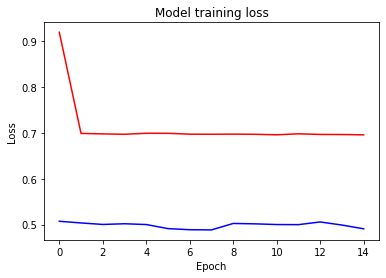

In [15]:
import matplotlib.pyplot as plt

plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [18]:
history_resnet_50.history

{'loss': [0.9199658632278442,
  0.6989937424659729,
  0.6979464292526245,
  0.6971418857574463,
  0.699307382106781,
  0.6992338299751282,
  0.6973613500595093,
  0.6971814632415771,
  0.6974321007728577,
  0.6970767378807068,
  0.6959982514381409,
  0.6981124877929688,
  0.6967800259590149,
  0.6966327428817749,
  0.6959354281425476],
 'accuracy': [0.49720311164855957,
  0.49870815873146057,
  0.5003770589828491,
  0.5064054131507874,
  0.4975777864456177,
  0.4905802607536316,
  0.5033347606658936,
  0.4966602027416229,
  0.500968873500824,
  0.5033372640609741,
  0.5005382895469666,
  0.5007535815238953,
  0.4983326196670532,
  0.49714499711990356,
  0.5074763298034668],
 'val_loss': [0.6968756318092346,
  0.6950346827507019,
  0.7036826610565186,
  0.6954041123390198,
  0.6942451000213623,
  0.6986580491065979,
  0.6978269815444946,
  0.6986823081970215,
  0.6953768730163574,
  0.6936815977096558,
  0.6934104561805725,
  0.6956963539123535,
  0.693341851234436,
  0.6933925151824951